In [1]:
## Script to analyze Turbo Typing data

Notes on where I'm leaving off:   
- 9/22/24 Just wrote code that removes the extra spaces before characters from the imported data without deleting actual spaces. Next I want to use the collapsed sentences with no extra s
- spaces to use the diff function and compare them.  
- 9/23/2024 Basically same goal for next time. I had to make a new column that replaces the multi-character key names with special characters for the keyData from the participants, which was completed today.
- 9/24/2024 Isolated correct keypress times. Next time, calculate ttk for correct presses, mean ttk, and the rest of the assessment variables. Also ask Patrick the best way to organize and write code.

In [2]:
import os
import numpy as np
import pandas as pd
import math
import glob
import editdistance
from scipy import stats
import diff_match_patch as dmp_module
dmp = dmp_module.diff_match_patch()
import copy
from scipy.stats import pearsonr
from scipy.stats import variation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import typingmod as typ

In [3]:
# Setting save directory
save_dir = r'/Users/rubi/Desktop/Github/typingexp/typing_task_analysis/'\
           'figures/'

In [4]:
# The imported data from Turbo Typing stores listed data as a long string. 
# This splits it up into actual lists.
def str_to_list(dataframe, columns):
    for col in columns:
        data_str = dataframe[col]
        if type(data_str.iloc[0]) == list:
            pass
        elif type(data_str.iloc[0]) == str:
            if data_str.iloc[0][0].isdigit() == True:
                data_list = data_str.apply(lambda trial: 
                                           [int(char) for char in trial.split(',')])
                dataframe[col] = data_list
            elif data_str.iloc[0][0].isdigit() == False:
                data_list = [x.split(',') for x in data_str]
                dataframe[col] = data_list
        else:
            print('Column must have data in string form.')

# Removes extra spaces before characters in keypress data.
def no_extra_spaces(dataframe, columns):
    for col in columns:
        no_space = dataframe[col].apply(lambda trial: 
                                        [char.replace(" ","") if char.isspace() 
                                         != True else ' ' for char in trial])
        dataframe[col] = no_space

# Changes multi-chracter keynames (ie. LeftShift and Backspace) to special
# characters.
def multi_to_special(dataframe, column):
    data = dataframe[column]
    edit_data = []
    for trial in data:
        edit_trial = copy.deepcopy(trial) # Pandas can't deep copy lists in dataframes, so this is a work around.
        for index, key in enumerate(edit_trial):
            if len(key) == 1:
                pass
            if len(key) > 1:
                if key in ['LeftShift', 'RightShift']:
                    edit_trial[index] = '#'
                elif key == 'Backspace':
                    edit_trial[index] = '-'
                elif key == 'Return':
                    edit_trial[index] = '^'
                else:
                    edit_trial[index] = '~' # '~' replaces any other keys longer than one character.
        edit_data.append(edit_trial)
    return edit_data

# Calculates time to keypress (TTK) for all presses in one trial.
# TTK is the reaction time for the first press and the interkey 
# interval for any subsequent presses.
def ttk(row, column):
    presses = pd.DataFrame(row.loc[column])
    ttk_df = presses.sub(presses.shift(fill_value=0))
    ttk_list = ttk_df.values.flatten().tolist()
    return ttk_list

# Creates a list of keys that would have been pressed if the sentence was typed
# with no errors (ie. no backspacing). Uses single, special characters to 
# represent multi-character key names (ie. '^' for 'Return').
def sentence_to_keydata(string):
    curr_keyData = []
    for index, data in enumerate(string):
        if data.isupper() == True:
            curr_keyData.append('#') # '#' Replaces 'Right/LeftShift'
            curr_keyData.append(data)
        elif data.isupper() == False and data.isalpha() or data.isspace() == True:
            curr_keyData.append(data)
        elif data == '?':
            curr_keyData.append('#')
            curr_keyData.append(data)
            curr_keyData.append('^')
        elif data == '.':
            curr_keyData.append(data)
            curr_keyData.append('^') # '^' Replaces 'Return'
    return curr_keyData

# # Splits up keyDataConverted data from a string to a list of pressed keys.
# def split_str(row):
#     keys_str = row.loc['keyDataConverted']
#     keys_list = keys_str.split(',')
#     return keys_list

In [5]:
# Getting subject data folders from server.
server = r'/Volumes/greenhouse/typingtask_data/subject_data'
os.chdir(server)
folders = os.listdir()

# Looping through subject folders, getting appropriate paths to data, 
# and making sID list.
sub_folders = list(filter(lambda x: x.startswith('s', 0, 1), folders))
all_turbo = pd.DataFrame()
ID_list = []
for sub in sub_folders:
    sub_folder = r'/Volumes/greenhouse/typingtask_data/'\
                 'subject_data/%s/turbotyping_data' % sub
    os.chdir(sub_folder)
    sID = sub.split('_', 1)[0]
    turbo = pd.read_csv(glob.glob('*_datafile.tsv')[0], sep='\t')
    all_turbo = pd.concat([all_turbo, turbo])
    ID_list.append(sID)

all_turbo = all_turbo.reset_index()

In [6]:
ID_list

['s262',
 's261',
 's240',
 's217',
 's176',
 's267',
 's263',
 's254',
 's209',
 's276',
 's278',
 's279',
 's282',
 's283',
 's286',
 's302',
 's304',
 's306',
 's305',
 's309',
 's311',
 's009',
 's020',
 's207',
 's313',
 's336',
 's344',
 's345',
 's347']

In [7]:
# Transforms listed data stored in long strings to actual lists.
str_to_list(all_turbo, ['timeData', 
                        'keyData', 
                        'keyDataConverted', 
                        'timeDataUp',
                        'keyDataUp'])

# Removes extra spaces before characters in keypress data columns.
no_extra_spaces(all_turbo, ['keyData', 'keyDataConverted', 'keyDataUp'])

# Replaces multi-character key names with single, special characters from key
# press data typed by participants. 
no_multichar_keys = multi_to_special(all_turbo, 'keyDataConverted')
all_turbo.insert(11, 'keyDataSpecialChar', no_multichar_keys)

# Creates column that represents the correct key press sequence if there were
# no errors (uses special characters for multi-character key names).
current_keyData = [sentence_to_keydata(x) for x in all_turbo['currentSentence']]
all_turbo.insert(8, 'keyDataCurrent', current_keyData)

In [8]:
# Compares the correct sequence of keypresses with what was typed during the 
# trial and returns the difference between the two.
string_diff = all_turbo.apply(lambda row: 
                            dmp.diff_main(''.join(row.loc['keyDataSpecialChar']), 
                                          ''.join(row.loc['keyDataCurrent'])),
                            axis=1)

# Separates the returned differences into individual characters.
diffs_bychar = []
for trial in string_diff:
    diff_bychar_trial = []
    for diff in trial:
        if len(diff[1]) == 1:
            diff_bychar_trial.append([diff[0], diff[1]])
        elif len(diff[1]) > 1:
            for char in diff[1]:
                diff_bychar_trial.append([diff[0], char])
    diffs_bychar.append(diff_bychar_trial)

# Differences for errors where participants swap two letters are solved as: 
# letter 2 subtraction, letter 1 retention, letter 2 addition. Because  
# both letters 1 and 2 need to be identified as incorrect keypresses, this code 
# changes the difference to show: letter 2 subtraction, letter 1 subtraction.
diffs_bychar_fixswap = []
for trial in diffs_bychar:
    chardiffs_trial = []
    char_toskip = 0
    for index, char in enumerate(trial):
        if char_toskip != 0:
            char_toskip = char_toskip - 1
            continue
        if char[0] == 0:
            if index == (len(trial) - 1) or index == 0:
                chardiffs_trial.append(char)
            else:
                if trial[index - 1][0] == -1 and trial[index + 1][0] == 1:
                    if trial[index - 1][1] == trial[index + 1][1]:
                        chardiffs_trial.append([-1, char[1]])
                        char_toskip = 1
                else:
                    chardiffs_trial.append(char)
        else:
            chardiffs_trial.append(char)
    diffs_bychar_fixswap.append(chardiffs_trial)

In [9]:
# Isolates characters and indices in original keyData/timeData lists for correct 
# keypresses and adds both to new columns.
corr_keys = []
corr_indices = []
for trial in diffs_bychar_fixswap:
    corr_keys_trial = []
    corr_indices_trial = []
    for index, char in enumerate(trial):
        if char[0] == 0:
            corr_keys_trial.append(char[1])
            corr_indices_trial.append(index)
        else:
            pass
    corr_keys.append(corr_keys_trial)
    corr_indices.append(corr_indices_trial)
    
all_turbo.insert(12, 'keyDataCorrect', corr_keys)
all_turbo.insert(13, 'keyIndicesCorrect', corr_indices)

In [10]:
# Isolates keypress times for correct keypresses and adds to a new column.
def corr_time(trial):
    times = trial.loc['timeData']
    indices = trial.loc['keyIndicesCorrect']
    matched_indices =[]
    for index, time in enumerate(times):
        if index in indices:
            matched_indices.append(time)
    return matched_indices

corr_times = all_turbo.apply(corr_time, axis=1)
all_turbo.insert(10, 'timeDataCorrect', corr_times)

In [11]:
# Calculates edit distance of each trial and stores to an additional column.
edit_dist = all_turbo.apply(lambda row: 
                            editdistance.eval(row.loc['currentSentence'], 
                                              row.loc['typedSentence']), 
                            axis=1)
all_turbo['editDistance'] = edit_dist

# Calculates TTK for every character typed in each trial and stores to 
# an additional column.
ttks = all_turbo.apply(lambda row: ttk(row, 'timeData'), axis=1)
all_turbo['ttk'] = ttks

# Calculates TTK for every character correctly typed in each trial and stores to 
# an additional column.
ttks_corr = all_turbo.apply(lambda row: ttk(row, 'timeDataCorrect'), axis=1)
all_turbo['ttkCorrect'] = ttks_corr

# Calculates mean TTK for each trial and stores to an additional column.
mean_ttk = [np.mean(x) for x in all_turbo['ttk']]
all_turbo['ttkMean'] = mean_ttk

# Calculates mean correct TTK for each trial and stores to an additional column.
mean_ttk_corr = [np.mean(x) for x in all_turbo['ttkCorrect']]
all_turbo['ttkMeanCorrect'] = mean_ttk_corr

# Calculates sum of all TTKs for each trial and stores to an additional column.
sum_ttk = [np.sum(x) for x in all_turbo['ttk']]
all_turbo['ttkSum'] = sum_ttk
all_turbo['ttkMean']

# Calculates sum of all correct TTKs for each trial and stores to an additional 
# column.
sum_ttk_corr = [np.sum(x) for x in all_turbo['ttkCorrect']]
all_turbo['ttkSumCorrect'] = sum_ttk_corr

In [12]:
# Calculates IES
def ies(row):
    mean_corr_rt = row['ttkMeanCorrect']
    pc = len(row['ttkCorrect'])/len(row['ttk'])
    return mean_corr_rt/pc

ies = all_turbo.apply(lambda row: ies(row), 
                      axis=1)
all_turbo['ies'] = ies

In [13]:
# Calculates rate correct score (RCS) for each trial and stores in column.
rcs = all_turbo.apply(lambda row: 
                      len(row.loc['ttkCorrect'])/row.loc['ttkSum'],
                      axis=1)
all_turbo['rcs'] = rcs

In [14]:
# Calculates linear integrated speed-ccuracy score (LISAS) and stores in column.
def lisas(row):
    rt_mean = row.loc['ttkMeanCorrect']
    rt_std = np.std(row.loc['ttkCorrect'])
    pe = 1-(len(row['ttkCorrect'])/len(row['ttk']))
    pe_std = np.sqrt(pe*(1-pe))
    return rt_mean + (np.std(rt_mean)/pe_std)*pe

lisas_output = all_turbo.apply(lambda row: lisas(row), axis=1)
all_turbo['lisas'] = lisas_output

/var/folders/42/sqkdrmx52wgfnxt8ycz1hhlc0000gn/T/ipykernel_85661/268902196.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return rt_mean + (np.std(rt_mean)/pe_std)*pe


In [15]:
# # Calculates BIS
# # by_sub = all_turbo.groupby('participantID')
# z_score = stats.zscore
# # by_sub = pd.DataFrame(all_turbo.groupby('participantID').filter(lambda x: print(x['trialNumber'])))
# ttkmean_bysub = pd.DataFrame(all_turbo[all_turbo['trialNumber'] >= 0].groupby('participantID').ttkMean)
# # totalttkmean_bysub = ttkmean_bysub
# # by_sub = by_sub.reset_index().rename(columns = {'ttk':'all_ttk'})
# # ttkmean_bysub
# # test = ttkmean_bysub.
# # test = ttkmean_bysub[1][0].mean()
# # test
# test = ttkmean_bysub[1].apply(lambda x: stats.zscore(x))
# # stats.zscore(ttkmean_bysub[1][0])
# # ttkmean_bysub
# # by_sub[1][0]
# # test
# # by_sub['all_ttk'].apply(stats.zscore)
# test = test.transpose()
# test

In [16]:
# Isolates keypress times for correctly typed alphabet characters (a-z) and adds 
# to a new column.
def alpha_time(row):
    trial = row.loc['keyDataCorrect']
    times = row.loc['timeData']
    alpha_indices = [index for (index, char) in enumerate(trial) if char.isalpha() == True]
    alpha_time = [time for (index, time) in enumerate(times) if index in alpha_indices]
    return alpha_time

alpha_times = all_turbo.apply(alpha_time, axis=1)
all_turbo.insert(11, 'timeDataAlpha', alpha_times)

# Calculates IKI (excludes first TTK) for correctly typed alphabet characters 
# (a-z) in each trial and stores to a new column.
ttks_alpha = all_turbo.apply(lambda row: ttk(row, 'timeDataAlpha'), axis=1)
ikis_alpha = [ttk[1:] for ttk in ttks_alpha]
all_turbo['ikiAlpha'] = ikis_alpha

# Calculates mean IKI for each trial and stores to new column. 
all_turbo['meanikiAlpha'] = [np.mean(ikis) for ikis in all_turbo.ikiAlpha]
all_turbo['sdikiAlpha'] = [np.std(ikis) for ikis in all_turbo.ikiAlpha]
all_turbo['cvikiAlpha'] = [variation(ikis) for ikis in all_turbo.ikiAlpha]

/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [17]:
# Calculates individual Mean IKI for correctly typed alphabet characters.
meanikis_alpha = all_turbo.groupby('participantID').meanikiAlpha.agg('mean').reset_index()

# Divides values by 1000 to put on same scale as mean IKIs from in-house typing
# task. 
def divby1000(value):
    return value/1000
meanikis_alpha['meanikiAlpha'] = meanikis_alpha.meanikiAlpha.transform(divby1000)
# meanikis_alpha

In [18]:
# Creating dataframe of subject score averages for each IES, RCS, and LISAS.
subject_scores = pd.DataFrame()
subject_scores['sID'] = ID_list
subject_scores = subject_scores.sort_values(by=['sID']).reset_index(drop = True)

# Adding mean IES scores.
mean_ies = all_turbo.groupby('participantID').ies.agg(['mean'])
mean_ies = mean_ies.sort_values(by=['participantID'])
subject_scores['mean_ies'] = mean_ies.reset_index()['mean']

# Adding mean IKIs for alphabetic characters.
meanikis_alpha = all_turbo.groupby('participantID').meanikiAlpha.agg('mean').reset_index()
def divby1000(value): # Divides values by 1000 to put on same scale as mean IKIs  
    return value/1000 # from in-house typing task.
meanikis_alpha['meanikiAlpha'] = meanikis_alpha.meanikiAlpha
meanikis_alpha = meanikis_alpha.sort_values(by=['participantID'])
subject_scores['meaniki_alpha'] = meanikis_alpha.reset_index()['meanikiAlpha']

# Adding SD IKIs for alphabetic characters.
sdikis_alpha = all_turbo.groupby('participantID').sdikiAlpha.agg('mean').reset_index()
def divby1000(value): # Divides values by 1000 to put on same scale as mean IKIs  
    return value/1000 # from in-house typing task.
sdikis_alpha['sdikiAlpha'] = sdikis_alpha.sdikiAlpha
sdikis_alpha = sdikis_alpha.sort_values(by=['participantID'])
subject_scores['sdiki_alpha'] = sdikis_alpha.reset_index()['sdikiAlpha']

# Adding CV IKIs for alphabetic characters.
cvikis_alpha = all_turbo.groupby('participantID').cvikiAlpha.agg('mean').reset_index()
cvikis_alpha = cvikis_alpha.sort_values(by=['participantID'])
subject_scores['cviki_alpha'] = cvikis_alpha.reset_index()['cvikiAlpha']

# Importing individual global scores calculated from typing task analysis script.
globals_dir = save_dir + '/indiv_globalmetrics.csv'
indiv_globals = pd.read_csv(globals_dir).drop(['Unnamed: 0'], axis = 1)
indiv_globals = indiv_globals[indiv_globals['sID'].isin(ID_list)]
indiv_globals = indiv_globals.sort_values(by=['sID']).reset_index(drop=True)

subject_scores = pd.concat([subject_scores, indiv_globals], axis = 1)

In [19]:
### ADDRESS/EDIT THIS LATER ###

# Dropping data from new subjects that won't be included in first paper.
subject_scores = subject_scores.dropna()
subject_scores

,sID,mean_ies,meaniki_alpha,sdiki_alpha,cviki_alpha,sID,mean_IKI,sd_IKI,cv_IKI,mean_RT,sd_RT,cv_RT,mean_deltaiki,total_deltaiki,mean_deltart,total_error
0,s009,258.931703,155.438234,109.777191,0.700639,s009,128.731285,66.845992,0.518988,632.400868,65.977277,0.104103,-0.002626,-0.008895,-0.012846,16.0
1,s020,473.267482,302.346982,250.453478,0.826906,s020,175.611799,98.927240,0.562998,1046.596674,236.034650,0.224991,0.000014,0.012050,-0.023708,45.0
2,s176,1682.851715,316.733664,241.706849,0.744973,s176,203.993805,85.075906,0.416814,910.562930,169.041712,0.185223,-0.005354,-0.008549,-0.021532,50.0
3,s207,360.885650,208.614089,141.033972,0.647481,s207,164.630828,85.433328,0.518637,869.909961,191.214049,0.219297,-0.001083,-0.020852,0.000042,53.0
4,s209,347.896285,216.724253,172.571811,0.786554,s209,134.535970,71.296370,0.529646,847.502334,132.069120,0.155484,-0.000394,-0.007713,-0.018694,40.0
5,s217,230.162116,157.551622,80.985323,0.503416,s217,136.208892,49.105129,0.360322,698.350715,123.779662,0.176868,0.000243,0.000984,-0.007439,18.0
6,s240,254.896620,151.232289,80.480261,0.528411,s240,153.041121,68.443047,0.446983,604.787952,129.136940,0.213071,-0.000812,-0.024345,-0.004336,10.0
7,s254,438.068837,301.408604,237.287035,0.781249,s254,253.690343,167.907755,0.661448,1095.387209,237.142440,0.215930,-0.000429,-0.006956,-0.007288,90.0
8,s261,346.531622,195.963325,142.673141,0.715762,s261,137.396953,65.836895,0.478910,731.690161,105.624396,0.144040,-0.003335,-0.010270,-0.010033,32.0
9,s262,227.275971,140.411655,84.362104,0.583585,s262,127.518855,56.049782,0.439301,654.595454,128.161686,0.195358,-0.002117,-0.015760,-0.019420,23.0


In [20]:
print(subject_scores['mean_ies'].mean())
print(subject_scores['mean_ies'].std())

416.7542988469906
289.4155458890047


In [21]:
# Pearson correlations between mean IES and typing task metrics.
main_metrics = indiv_globals.columns.tolist()
main_metrics.remove('sID')
main_metrics.remove('total_deltaiki')

ies_pearsons = []
for metric in main_metrics:
    corr = pearsonr(subject_scores['mean_ies'],
               subject_scores[metric])
    ies_pearsons.append([metric, corr[0], corr[1]])

ies_pearsons = pd.DataFrame(ies_pearsons).sort_values(1)
ies_pearsons = ies_pearsons.rename(columns={0: 'metric',
                                            1: 'r_stat',
                                            2: 'p_val'})

ies_pearsons

,metric,r_stat,p_val
6,mean_deltaiki,-0.251706,0.235427
7,mean_deltart,-0.125026,0.560505
2,cv_IKI,0.002530,0.990639
5,cv_RT,0.008540,0.968409
4,sd_RT,0.198856,0.351577
1,sd_IKI,0.212472,0.318876
8,total_error,0.325689,0.120408
0,mean_IKI,0.346269,0.097410
3,mean_RT,0.365305,0.079202


In [22]:
custom_divergent = []
custom_divergent[0:3] = sns.color_palette('RdPu_r')[1:6].copy()
custom_divergent[4:8] = sns.color_palette('PuBu')[0:5].copy()
# custom_palette = sns.set_palette(sns.color_palette(custom_divergent))
# custom = sns.set_palette(sns.color_palette(custom_divergent, n_colors=9))
custom = sns.color_palette(custom_divergent)
custom

[(0.735840061514802, 0.061960784313725495, 0.5225682429834679),
 (0.9094502114571319, 0.2894886582083814, 0.6086120722798923),
 (0.9754555940023067, 0.5330257593233372, 0.6768935024990388),
 (0.9859592464436755, 0.7293041138023837, 0.7404229142637447),
 (0.9112802768166091, 0.894717416378316, 0.9429296424452134),
 (0.7678892733564013, 0.7968473663975394, 0.889442522106882),
 (0.5687043444828912, 0.7082660515186466, 0.8390772779700115),
 (0.31378700499807766, 0.6058439061899269, 0.7776239907727797),
 (0.07537101114955785, 0.4756324490580546, 0.7084044598231449)]

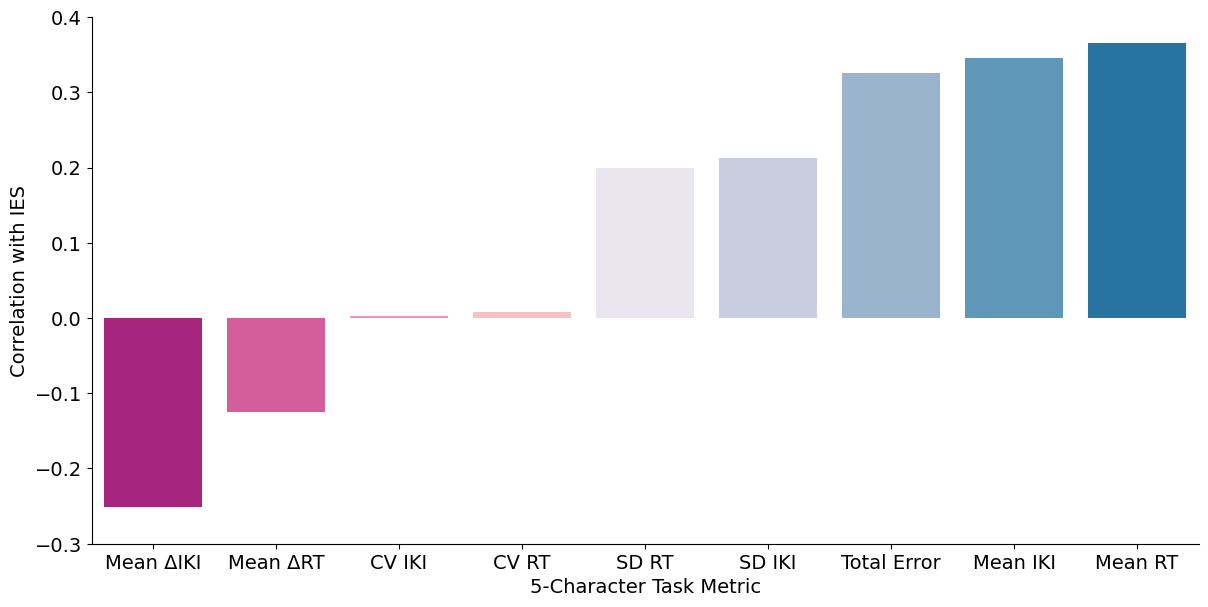

In [23]:
# Fig. 3b - Pearson correlations between IES and all collected metrics during
# 5-character typing task
g = sns.catplot(ies_pearsons, x='metric', y='r_stat', kind='bar',
                hue='metric', palette=custom, height=6, aspect=2)

# Setting axis labels
g.set_axis_labels("5-Character Task Metric", "Correlation with IES", 
                  fontsize=14)

# Setting tick labels
g.set_yticklabels(fontsize=14)
g.set_xticklabels(['Mean ΔIKI', 'Mean ΔRT', 'CV IKI', 'CV RT', 'SD RT', 
                   'SD IKI', 'Total Error', 'Mean IKI', 'Mean RT'],
                  fontsize=14)

# Setting y-lim
plt.ylim(-0.3, 0.4)
    
plt.show()
g.savefig(save_dir + 'fig_3b.png', dpi=300)

In [24]:
# Pearson correlation between mean, SD, and CV IKI from Turbo and Typing tasks.
print('Mean IKI:', pearsonr(subject_scores['meaniki_alpha'],
               subject_scores['mean_IKI']))
print('SD IKI:', pearsonr(subject_scores['sdiki_alpha'],
               subject_scores['sd_IKI']))
print('CV IKI:', pearsonr(subject_scores['cviki_alpha'],
               subject_scores['cv_IKI']))

# Making list of Pearson results. 
alpha_pearsons = [
    (pearsonr(subject_scores['meaniki_alpha'], 
              subject_scores['mean_IKI'])),
    (pearsonr(subject_scores['sdiki_alpha'],
              subject_scores['sd_IKI'])),
    (pearsonr(subject_scores['cviki_alpha'],
              subject_scores['cv_IKI']))]

# List of only p-values
alpha_pvals = [val[1] for val in alpha_pearsons]

# Running Bonferonni correction
bon_alphaps = [p*len(alpha_pvals) for p in alpha_pvals]
print('Bonferonni p-vals', bon_alphaps)

# Running False Discovery Rate test
print('FDR p-vals', stats.false_discovery_control(alpha_pvals))

Mean IKI: PearsonRResult(statistic=0.8316380189472556, pvalue=4.7646311003178197e-07)
SD IKI: PearsonRResult(statistic=0.7582403516220454, pvalue=1.7641067313842213e-05)
CV IKI: PearsonRResult(statistic=0.7451056087899841, pvalue=2.951551676149742e-05)
Bonferonni p-vals [1.429389330095346e-06, 5.292320194152664e-05, 8.854655028449226e-05]
FDR p-vals [1.42938933e-06 2.64616010e-05 2.95155168e-05]


In [25]:
alpha_pearsons = pd.DataFrame(np.array([pearsonr(subject_scores['meaniki_alpha'],
                                      subject_scores['mean_IKI']),
                                      pearsonr(subject_scores['sdiki_alpha'],
                                      subject_scores['sd_IKI']), 
                                      pearsonr(subject_scores['cviki_alpha'],
                                      subject_scores['cv_IKI'])]),
                             columns=['r_stat', 'p_val'])
alpha_pearsons['metric'] = ['mean_IKI', 'sd_IKI', 'cv_IKI']

alpha_pearsons['p_val'] = [p*len(alpha_pearsons['p_val']) for p in alpha_pearsons['p_val']]

alpha_pearsons

,r_stat,p_val,metric
0,0.831638,0.000001,mean_IKI
1,0.758240,0.000053,sd_IKI
2,0.745106,0.000089,cv_IKI


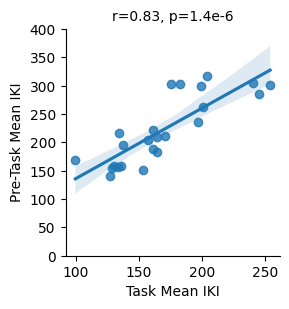

In [34]:
# Fig. 3c1 - Turbo mean IKI vs. Task mean IKI
g = sns.lmplot(
    data=subject_scores,
    x="mean_IKI", y="meaniki_alpha",
    height=3
)

g.set_axis_labels('Task Mean IKI', 'Pre-Task Mean IKI', fontsize=10)

plt.ylim(0, 400)

# g.set_yticklabels(fontsize=8)
# g.set_xticklabels(fontsize=8)

g.ax.set_title('r=0.83, p=1.4e-6', fontsize=10)

plt.show()
g.savefig(save_dir + 'fig_3c1.png', dpi=300)

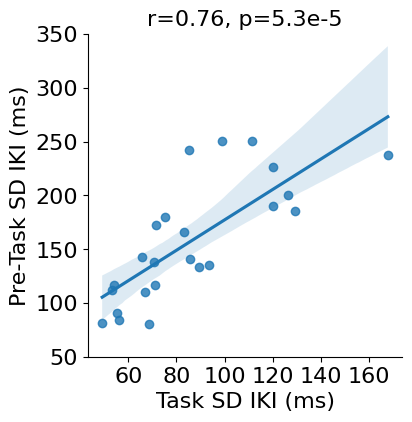

In [53]:
# Fig. 3c2 - Turbo SD IKI vs. Task SD IKI
g = sns.lmplot(
    data=subject_scores,
    x="sd_IKI", y="sdiki_alpha",
    height=4
)

g.set_axis_labels('Task SD IKI (ms)', 'Pre-Task SD IKI (ms)', fontsize=16)

# for paper
# plt.ylim(0, 400)

# for grant
plt.ylim(50, 350)

# g.set_yticklabels(fontsize=12)
# g.set_xticklabels(fontsize=12)

g.ax.set_title('r=0.76, p=5.3e-5', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig(save_dir + 'turbovtask_sd_TL1.png', dpi=300, bbox_inches="tight")
plt.show()
# g.savefig(save_dir + 'fig_3c2.png', dpi=300)


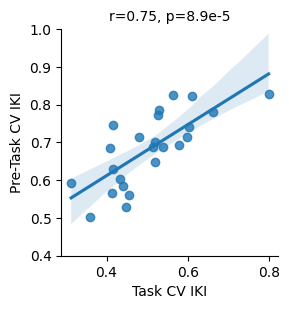

In [28]:
# Fig. 3c3 - Turbo CV IKI vs. Task CV IKI
g = sns.lmplot(
    data=subject_scores,
    x="cv_IKI", y="cviki_alpha",
    height=3
)

g.set_axis_labels('Task CV IKI', 'Pre-Task CV IKI', fontsize=10)

plt.ylim(0.4, 1)

# g.set_yticklabels(fontsize=12)
# g.set_xticklabels(fontsize=12)

g.ax.set_title('r=0.75, p=8.9e-5', fontsize=10)

plt.show()
g.savefig(save_dir + 'fig_3c3.png', dpi=300)

In [29]:
## Pearson correlation between ... 
ies_pearsons = [
    (pearsonr(subject_scores['mean_ies'],
             subject_scores['mean_IKI'])),
    (pearsonr(subject_scores['mean_ies'],
               subject_scores['sd_IKI'])),
    (pearsonr(subject_scores['mean_ies'],
               subject_scores['cv_IKI'])),
    (pearsonr(subject_scores['mean_ies'],
               subject_scores['mean_RT'])),
    (pearsonr(subject_scores['mean_ies'],
               subject_scores['sd_RT'])),
    (pearsonr(subject_scores['mean_ies'],
               subject_scores['cv_RT'])),
    (pearsonr(subject_scores['mean_ies'],
               subject_scores['mean_deltaiki'])),
    (pearsonr(subject_scores['mean_ies'],
               subject_scores['total_deltaiki'])),
    (pearsonr(subject_scores['mean_ies'],
               subject_scores['mean_deltart']))
] 

# List of only p-values
pvals = [val[1] for val in ies_pearsons]

# Running Bonferonni correction
bon_ps = [p*len(pvals) for p in pvals]

# Running False Discovery Rate test
stats.false_discovery_control(pvals)

array([0.43834322, 0.63283802, 0.99063852, 0.43834322, 0.63283802,
       0.99063852, 0.63283802, 0.99063852, 0.84075708])

In [30]:
x = pearsonr(subject_scores['mean_ies'],
               subject_scores['mean_deltart'])